In [1]:
import os
import tensorflow as tf
print("tensorflow version = {}".format(tf.__version__))
print("keras version = {}".format(tf.keras.__version__))

tensorflow version = 2.4.1
keras version = 2.4.0


In [2]:
dataDir = 'rockpaperscissors'
os.listdir(dataDir)

['paper', 'README_rpc-cv-images.txt', 'rock', 'scissors']

In [3]:
import pathlib

image_count = len(list(pathlib.Path(dataDir).glob('*/*.PNG')))
print(image_count)

2188


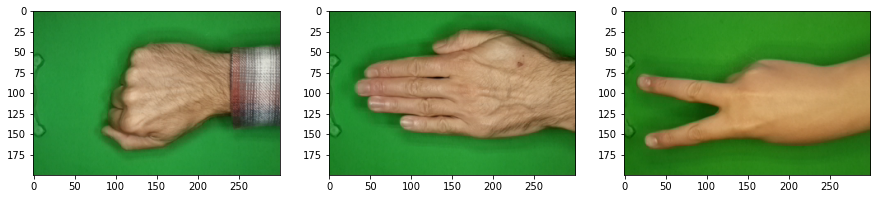

In [4]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
%matplotlib inline

rock = list(pathlib.Path(dataDir).glob("rock/*"))
paper = list(pathlib.Path(dataDir).glob("paper/*"))
scissors = list(pathlib.Path(dataDir).glob("scissors/*"))

plt.figure(1, figsize=(15, 4))
plt.subplot(131)
plt.imshow(mpimg.imread(str(rock[1])))
plt.subplot(132)
plt.imshow(mpimg.imread(str(paper[1])))
plt.subplot(133)
plt.imshow(mpimg.imread(str(scissors[1])))

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    validation_split = 0.4,
    rescale = 1./255,
    rotation_range = 20,
    horizontal_flip = True,
    shear_range = 0.2,
    zoom_range=0.2,
    fill_mode = 'nearest'
)

In [6]:
imgHeight = 150
imgWidth = 150

trainGenerator = datagen.flow_from_directory(
    dataDir,
    subset = "training",
    seed = 42,
    target_size = (imgHeight, imgWidth),    
)

valGenerator = datagen.flow_from_directory(
    dataDir,
    subset = "validation",
    seed = 42,
    target_size = (imgHeight, imgWidth),    
)
numClasses = trainGenerator.num_classes


Found 1314 images belonging to 3 classes.
Found 874 images belonging to 3 classes.


In [7]:
def generatorToTfdata(generator, input_shape):
    numClasses = generator.num_classes
    tfGenerator = tf.data.Dataset.from_generator(
        lambda: generator,
        output_types=(tf.float32, tf.float32),
        output_shapes=([None,
        input_shape[0],
        input_shape[1],
        input_shape[2]],
        [None, numClasses])
    )
    return tfGenerator

trainTfData = generatorToTfdata(trainGenerator, trainGenerator.image_shape)

valTfData = generatorToTfdata(valGenerator, valGenerator.image_shape)

In [8]:
print("type datagenerator: {}".format(type(trainGenerator)))
print("type ts_data: {}".format(type(trainTfData)))

type datagenerator: <class 'tensorflow.python.keras.preprocessing.image.DirectoryIterator'>
type ts_data: <class 'tensorflow.python.data.ops.dataset_ops.FlatMapDataset'>


In [9]:
inputShape = trainGenerator.image_shape
inputShape

(150, 150, 3)

In [10]:
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.applications import VGG16

pretrainedModel = VGG16(
    input_shape=inputShape,
    include_top=False,
    weights="imagenet",
    classes=numClasses
)

model = Sequential([
    # layers.Input(shape=inputShape),
    # layers.ZeroPadding2D(padding=(2, 2), input_shape=inputShape),
    # layers.ZeroPadding2D(padding=(2, 2)),
    # layers.Conv2D(3, (5, 5), strides=(1, 1), activation='relu'),
    # layers.MaxPooling2D(2, 2),
    # layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu'),
    # layers.MaxPooling2D(2, 2),
    # layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu'),
    # layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu'),
    pretrainedModel,
    # layers.GlobalAveragePooling2D(),
    layers.Dropout(0.2),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(64, activation='relu'),
    layers.Dense(numClasses, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d (Gl (None, 512)               0         
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
flatten (Flatten)            (None, 512)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               131328    
_________________________________________________________________
dense_1 (Dense)              (None, 64)                16448     
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 1

In [11]:
adam = tf.keras.optimizers.Adam(lr=0.0001)
model.compile(loss='categorical_crossentropy',
              optimizer=adam,
              metrics=['accuracy'])

In [35]:
es = tf.keras.callbacks.EarlyStopping(
      monitor="val_accuracy",
      patience=3,
      mode="max",
      # min_delta=1,
      verbose=1
      # restore_best_weights=True,
      # baseline=1
)

mc = tf.keras.callbacks.ModelCheckpoint(
      'best_model.h5', 
      monitor='val_accuracy', 
      mode='max', 
      verbose=1, 
      save_best_only=True
)

# tensorBoard = tf.keras.callbacks.TensorBoard(log_dir='./Graph')
callbacks = [es, mc]
history = model.fit(
      trainTfData,
      steps_per_epoch=10,  # berapa batch yang akan dieksekusi pada setiap epoch
      epochs=2000,
      validation_data=valTfData, # menampilkan akurasi pengujian data validasi
      validation_steps=5,  # berapa batch yang akan dieksekusi pada setiap epoch
      verbose=1,
      callbacks=callbacks)

Epoch 1/2000
10/10 [==============================] - 394s 40s/step - loss: 0.0570 - accuracy: 0.9812 - val_loss: 0.1353 - val_accuracy: 0.9625

Epoch 00001: val_accuracy improved from -inf to 0.96250, saving model to best_model.h5
Epoch 2/2000
10/10 [==============================] - 357s 36s/step - loss: 0.0541 - accuracy: 0.9897 - val_loss: 0.0124 - val_accuracy: 0.9937

Epoch 00002: val_accuracy improved from 0.96250 to 0.99375, saving model to best_model.h5
Epoch 3/2000
10/10 [==============================] - 387s 39s/step - loss: 0.0383 - accuracy: 0.9875 - val_loss: 0.0035 - val_accuracy: 1.0000

Epoch 00003: val_accuracy improved from 0.99375 to 1.00000, saving model to best_model.h5
Epoch 4/2000
10/10 [==============================] - 379s 38s/step - loss: 0.0041 - accuracy: 1.0000 - val_loss: 0.0318 - val_accuracy: 0.9855

Epoch 00004: val_accuracy did not improve from 1.00000
Epoch 5/2000
10/10 [==============================] - 384s 39s/step - loss: 0.0257 - accuracy: 0.9

(0.0, 1.0)

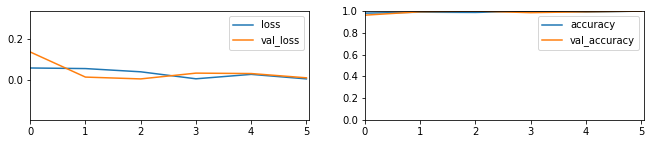

In [36]:
fig, axes = plt.subplots(1, 2, figsize=(11, 2))
ax = axes.ravel()

ax[0].plot(history.history['loss'])
ax[0].plot(history.history['val_loss'])

ax[0].legend(['loss', 'val_loss'])
ax[0].set_xlim([0, len(history.history['loss'])-0.95])
ax[0].set_ylim([min(history.history['val_loss'])-0.2, max(history.history['val_loss'])+0.2])

ax[1].plot(history.history['accuracy'])
ax[1].plot(history.history['val_accuracy'])

ax[1].legend(['accuracy', 'val_accuracy'])
ax[1].set_xlim([0, len(history.history['accuracy'])-0.95])
ax[1].set_ylim([0, 1])

In [37]:
testDir = "rockpaperscissors-TEST"
testData = os.listdir(testDir)

In [38]:
from tensorflow.keras.models import load_model

saved_model = load_model('best_model.h5')

In [39]:
modelScore = saved_model.evaluate_generator(valTfData,steps=10)
print("Model Test Loss: {:.2f}".format(modelScore[0]))
print("Model Test Accuracy: {:.2f}".format(modelScore[1]))

Model Test Loss: 0.01
Model Test Accuracy: 0.99


[[2.2746121e-08 1.0000000e+00 7.1961220e-13]]
[[1.0000000e+00 0.0000000e+00 1.3334819e-20]]
[[1.0000000e+00 0.0000000e+00 2.8792987e-11]]
[[0. 1. 0.]]
[[0. 1. 0.]]
[[2.5972872e-08 1.0000000e+00 1.6128247e-19]]
[[1. 0. 0.]]
[[0. 1. 0.]]
[[0. 0. 1.]]


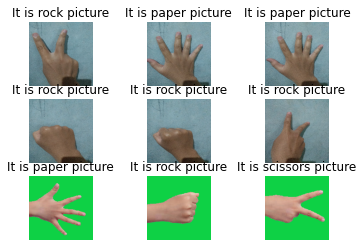

In [40]:
import numpy as np
from tensorflow.keras.preprocessing import image

for fn, i in zip(testData, range(len(testData))):
    path = os.path.join(testDir, fn)
    img = image.load_img(path, target_size=(150, 150))

    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(img)

    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)

    images = np.vstack([x])
    classes = saved_model.predict(images, batch_size=10)
    print(classes)
    
    if classes[0][0] == 1:
        label = 'paper'
    elif classes[0][1] == 1:
        label = 'rock'
    else:
        label = 'scissors'

    plt.title("It is "+label+" picture")
    plt.axis("off")